In [1]:
import tensorflow as tf
from tf_explain.core.grad_cam import GradCAM
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt
import cv2
# Load pretrained model or your own
model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=True)

Using TensorFlow backend.


In [2]:
def inference(img):
    x = np.copy(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    c = model.predict(x)
    m = np.argmax(c[0])
    print('class score: ', c[0][m])
    name = decode_predictions(preds, top=1)[0][0][1]
    imagenet_code = decode_predictions(preds, top=1)[0][0][0]
    return name, int(m), imagenet_code

In [3]:
def load_image(img_path):
    # Load a sample image (or multiple ones)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    data = ([np.copy(img)], None)
    return data, img

In [4]:
def get_mask(grid, thr=170):
    g = np.copy(grid)
    g = g.astype(np.float64)
    out_mask = g[:,:,0]+g[:,:,1]+g[:,:,2]
    out_mask //=3
    return out_mask>thr

In [14]:
def explain_and_mask(img_path, model, thr=170):
    data, img = load_image(img_path)
    name, class_index, imagenet_code = inference(img)
    print(name)
    print(class_index)
    print(imagenet_code)
    explainer = GradCAM()
    grid = explainer.explain(data, model,image_weight=0,
                             colormap=cv2.COLORMAP_BONE , class_index=class_index)  # 281 is the tabby cat index in ImageNet
    out_mask=get_mask(grid, thr)
    out_mask = out_mask.astype(np.uint8)
    out_mask[out_mask==1]=255
    #mask = cv2.bitwise_not(out_mask)
    mask = out_mask
    img = img.astype(np.uint8)
    m= cv2.merge([mask,mask,mask])
    occluded_img = cv2.bitwise_and(img, m)

    return img, occluded_img

In [167]:
img, occluded_img = explain_and_mask("./images/photo_2020-05-07_23-56-19.jpg", model)

class score:  0.25263456
pot
738
n03991062


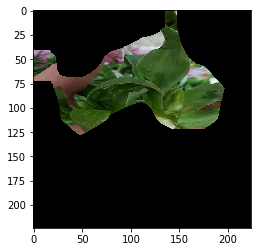

In [168]:
plt.imshow(occluded_img, cmap='gray')

In [169]:
inference(img)

class score:  0.25263456


('pot', 738, 'n03991062')

In [170]:
inference(occluded_img)

class score:  0.20027807


('broccoli', 937, 'n07714990')